<a href="https://colab.research.google.com/github/ParsecInstitute/Astromatic2022/blob/main/Problems/P5_OMM_Denoising/P5_Denoise_OMM_DiffusionAlgo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Autoencoder for denoising (put in the pipeline at the Mont-Mégantic)

Contacts: Carter and Alex

### Problem description
L'Observatoire de Mont Mégantic is run, in part, by the University of Montreal's astronomy department. One of the two primary imagers on the telescope, PESTO, is used by CRAQ astronomers to image beautiful galaxies and nebulae. However, do to less-than-ideal atmospheric conditions, these images can be heavily distorted or populated with noise.  

The goal of this project is to construct an algorithm that can denoise the images of galaxies and nebulae to be used to improve the quality of telescope images and generate full or partial images with a diffusion process!

### What is the potential solution to this problem?
The most straight-forward solution is to use an autoencoder. But you could also consider using other networks such as a U-net, RedNet, MWCNN, or PRIDNet.

### Data
We provided for you a curated sampled from the COSMOS survey. The data here is of a smaller dimension than the standard OMM data (128x128 instead of 1024x1024. The test set will be real OMM data that has been downgraded to the size of 128x128.

### Milestones estimators : 
- Use autoencoder on OMM-like images
- Use UNet on OMM-like Images
- Use network on real OMM images
- Generate realistic images from the noise OMM data using a diffusion model

You can take inspiration from [Schmidt et al. (2021)](https://arxiv.org/abs/2111.01713) implementation here 
https://github.com/Smith42/astroddpm.

## List of 5 papers that might be of help.
- https://arxiv.org/abs/1912.13171
- https://www.sciencedirect.com/science/article/abs/pii/S0893608020302665
- https://alain.xyz/blog/machine-learning-denoising
- https://proceedings.neurips.cc/paper/2012/file/6cdd60ea0045eb7a6ec44c54d29ed402-Paper.pdf
- https://iopscience.iop.org/article/10.1088/1742-6596/1176/2/022010/meta


## Setup

Below we provide you with a PyTorch dataset wrapping the COSMOS images.

In [ ]:
from google.colab import drive
import h5py
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm.auto import trange


drive.mount('/content/drive')
%cd drive/MyDrive/Astromatic2022-Data/Problems/Problem5/
filename = "cosmos_23.5_128_augmented_denoised.h5"
DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1mBGzkBzUrABCYLV72dzeA7ktapLpAcZF/Astromatic2022-Data/Problems/Problem5


In [ ]:
class COSMOS(Dataset):
    def __init__(self, path_to_cosmos):
        self.filename = path_to_cosmos
        self.h5_file = h5py.File(self.filename, mode="r")
        self.size = self.h5_file["galaxies"].shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, index):
        return torch.tensor(self.h5_file["galaxies"][index]).float()

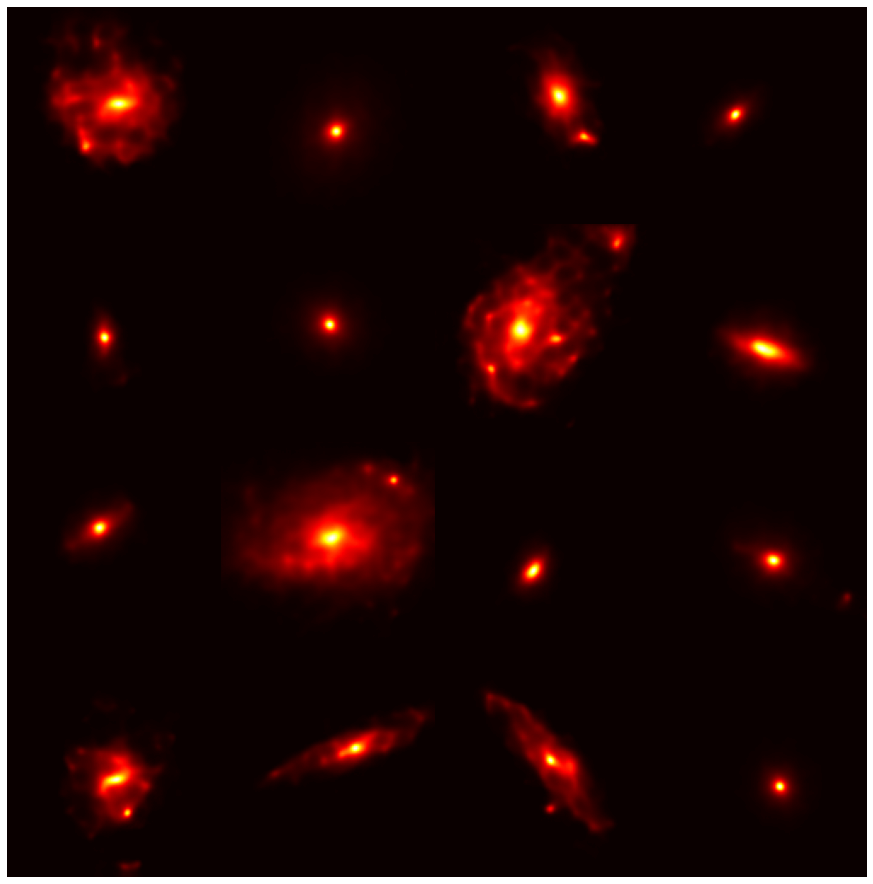

In [ ]:
# Plot images for fixed noise level
dataset = COSMOS(filename)

sqrt_n_images = 4
fig, axes = plt.subplots(
    sqrt_n_images, sqrt_n_images, figsize=(4 * sqrt_n_images, 4 * sqrt_n_images)
)

idx_start = 2100
for i, ax in enumerate(axes.flatten()):
    ax.imshow(dataset[i + idx_start], cmap="hot")
    ax.axis("off")

plt.subplots_adjust(wspace=-0.15, hspace=0)

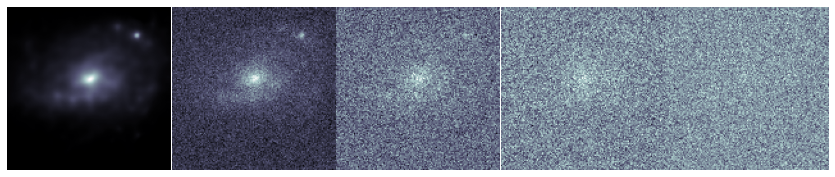

In [ ]:
# Plot images for different noise levels
dataset = COSMOS(filename)

fig, axs = plt.subplots(1, 5, figsize=(15, 3))
idx = 2109
for ax, sigma_noise in zip(axs, [0.0, 0.1, 0.3, 0.5, 1.5]):
    # Add noise
    x = dataset[idx]
    x_noisy = x + torch.randn_like(x) * sigma_noise
    
    ax.imshow(x_noisy, cmap="bone")
    ax.axis("off")
plt.subplots_adjust(hspace=0, wspace=-0.08)

## Inference

Now that you have a dataset, you'll need to decide on a network architecture and set up the training and validation dataloading. You'll also need to decide on the noise levels.

In [ ]:
# TODO: define network
class Network(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, x):
        ...

In [ ]:
dataset = COSMOS(filename)

In [ ]:
# Initialize network
network = Network()
network.to(DEVICE)  # put network on GPU

# Initialize dataset with a small amount of noise
sigma_noise = 0.05  # roughly the OMM noise level

# Get dataset sizes and make train-val-test split
train_frac = 0.8
val_frac = 0.1
n_all = len(dataset)
n_train = int(train_frac * n_all)
n_val = int(val_frac * n_all)
n_test = n_all - n_train - n_val
ds_train, ds_val, ds_test = random_split(dataset, [n_train, n_val, n_test])

# Wrap in dataloaders
batch_size = 64  # feel free to change!
num_workers = 2  # set to 0, 1 or 2
dl_train = DataLoader(ds_train, batch_size, shuffle=True, num_workers=num_workers)
dl_val = DataLoader(ds_val, batch_size, shuffle=False, num_workers=num_workers)
dl_test = DataLoader(ds_test, batch_size, shuffle=False, num_workers=num_workers)

n_epochs = 1
losses = []
losses_val = []
for epoch in trange(n_epochs):
    # Train
    network.train()
    for batch in dl_train:
        # Put batch on GPU
        batch = batch.to(DEVICE)
        # Add noise
        batch_noisy = batch + torch.randn_like(batch) * sigma_noise

        # Reset the optimizer
        # optimizer.zero_grad()

        # Predict!
        # batch_recon = network(batch_noisy)

        # Compute loss, backpropagate and take an optimization ste[p]
        # loss = loss_fn(batch_recon, batch)
        # loss.backward()
        # optimizer.step()

        # Save minibatch loss
        # losses.append(loss.item())

        # print("Stopping after 1 training batch")
        # break
    print("done training!")
    
    # Validate
    network.eval()
    with torch.no_grad():
        for batch in dl_val:
            # Put batch on GPU
            batch = batch.to(DEVICE)
            # Add noise
            batch_noisy = batch + torch.randn_like(batch) * sigma_noise

            # Predict and get loss
            # batch_recon = network(batch_noisy)
            # loss_val = loss_fn(batch_recon, batch)

            # Save minibatch loss
            # losses_val.append(loss_val.item())

            # print("Stopping after 1 validation batch")
            # break
        print("done validating!")

print("done!")

  0%|          | 0/1 [00:00<?, ?it/s]

done training!
done validating!
done!
